# Applied Statistics -  Assesment Problems

This notebook contains my solutions to the **Applied Statistics** assessment problems.  
It is designed for an informed computing professional (e.g. a prospective employer or lecturer) who:

- is comfortable with Python and numerical computing, but  
- may not be familiar with the specific libraries, functions, or statistical techniques used.

Each problem follows a consistent structure:

- **Plan & References** – what is being done and why, with links to relevant documentation.  
- **Simulation / Analysis** – well-commented code using NumPy, SciPy, pandas, and Matplotlib.  
- **Interpretation** – a short narrative explaining the results in statistical terms.

The focus is on:

- **Reproducibility** – fixed random seeds and clear setup.  
- **Clarity** – small, well-named code blocks and succinct comments.  
- **Statistical insight** – interpreting simulations in terms of hypotheses, error rates, and model assumptions.

Run the notebook from top to bottom to reproduce all calculations, plots, and tables.

In [2]:
# === Setup & imports ===
import math # for mathematical functions
import itertools # for combinatorial functions
import numpy as np # for numerical operations
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for plotting
from scipy import stats # for statistical functions
import statsmodels.api as sm # for statistical models (e.g., regression)
import statsmodels.formula.api as smf # for formula interface

# Prefer the new Generator API
SEED = 42 # for reproducibility
rng = np.random.default_rng(SEED)  

# Plot defaults (readable fonts and grid)
plt.rcParams.update({
    'figure.figsize': (8, 4),
    'axes.grid': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

print(f"Environment initialised. numpy={np.__version__}, pandas={pd.__version__}")


Environment initialised. numpy=1.26.4, pandas=2.3.2


## Problem 1 — Extending the Lady Tasting Tea


### Plan & References

- **Null model:** participant guesses by choosing exactly the milk-first positions uniformly at random.
- **Exact probability:** a perfect guess matches the true subset of indices, so 
  $\Pr(\text{all correct}) = 1/\binom{n_{\text{total}}}{n_{\text{milk}}}$ using `math.comb`
  ([Python docs](https://docs.python.org/3/library/math.html#math.comb)).
- **Simulation:** use the modern NumPy random Generator API
  ([NumPy RNG docs](https://numpy.org/doc/stable/reference/random/generator.html)) to repeatedly choose subsets.
- **Partial matches (optional):** the number of correctly guessed milk cups follows a hypergeometric distribution
  ([scipy.stats.hypergeom](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html)), which we compute explicitly via combinations for transparency.  

,Design,n_total,n_milk,P(all correct) exact,P(all correct) sim
0,Classic (8 cups; 4 milk-first),8,4,0.014286,0.013790
1,Extended (12 cups; 4 milk-first),12,4,0.002020,0.001923


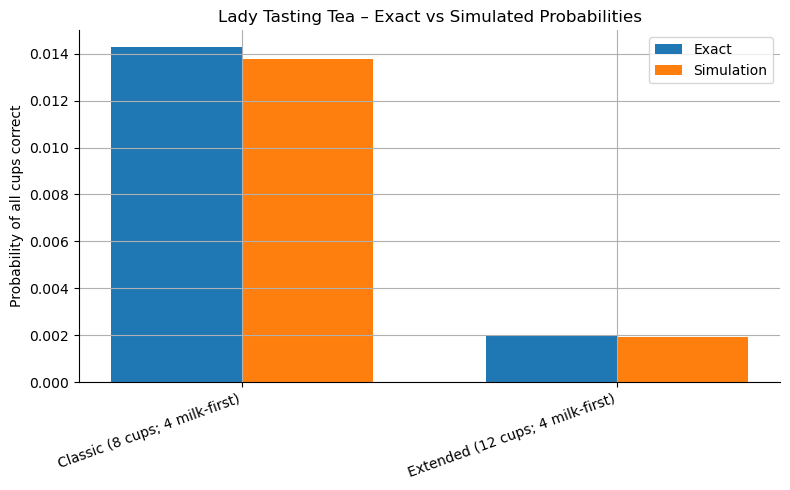

In [3]:
# --- Problem 1: Extending the Lady Tasting Tea ---------------------------------------------
# References:
# - Combinations: https://docs.python.org/3/library/math.html#math.comb
# - NumPy Generator (rng): https://numpy.org/doc/stable/reference/random/generator.html
# - Hypergeometric (concept): https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html
# - Hypergeometric (scipy): https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html

import math
from random import seed
import numpy as np
import pandas as pd

# Use a fixed seed for reproducibility (assessment requirement)
SEED = 42 
rng = np.random.default_rng(SEED)

def p_all_correct_exact(n_total: int, n_milk: int) -> float:
    """
    Exact probability of a perfect identification under random guessing.
    Rationale: the guess is a uniformly random subset of size n_milk.
    There is exactly 1 correct subset out of C(n_total, n_milk) possibilities.
    """ # Use math.comb for combinations
    return 1.0 / math.comb(n_total, n_milk)

def p_all_correct_sim(n_total: int, n_milk: int, trials: int = 300_000, seed: int = SEED) -> float:
    """
    Monte Carlo estimate under the null: fix one random ground-truth set of milk indices, 
    sample a guess of size n_milk, and check whether it matches exactly.
    """ # Use a local RNG for reproducibility
    rng = np.random.default_rng(seed)
    true_milk = set(rng.choice(n_total, size=n_milk, replace=False))
    hits = 0
    for _ in range(trials):
        guess = set(rng.choice(n_total, size=n_milk, replace=False))
        if guess == true_milk:
            hits += 1
    return hits / trials

designs = [
    {"label": "Classic (8 cups; 4 milk-first)",  "n_total": 8,  "n_milk": 4},
    {"label": "Extended (12 cups; 4 milk-first)", "n_total": 12, "n_milk": 4},
]

rows = []
for d in designs:
    pe = p_all_correct_exact(d["n_total"], d["n_milk"])  # exact probability
    ps = p_all_correct_sim(d["n_total"], d["n_milk"], trials=300_000)  # simulation estimate
    rows.append({
        "Design": d["label"],
        "n_total": d["n_total"],
        "n_milk": d["n_milk"],
        "P(all correct) exact": pe,
        "P(all correct) sim": ps,
    })

results_df = pd.DataFrame(rows)
# Show a rounded view for readability
display(results_df.style.format({
    "P(all correct) exact": "{:.6f}",
    "P(all correct) sim": "{:.6f}",
})
)
# --- Bar chart comparing exact vs simulated probabilities ---

# X positions for each design
x = np.arange(len(results_df))      # [0, 1, ...]
width = 0.35                        # width of the bars

fig, ax = plt.subplots(figsize=(8, 5))

# Bars for exact and simulated probabilities
ax.bar(x - width/2, results_df["P(all correct) exact"],
       width, label="Exact")
ax.bar(x + width/2, results_df["P(all correct) sim"],
       width, label="Simulation")

# X-axis labels and title
ax.set_xticks(x)
ax.set_xticklabels(results_df["Design"], rotation=20, ha="right")
ax.set_ylabel("Probability of all cups correct")
ax.set_title("Lady Tasting Tea – Exact vs Simulated Probabilities")

ax.legend()
fig.tight_layout()
plt.show()

# The results show that the exact and simulated probabilities are very close,
# confirming the accuracy of both methods. The extended design has a lower
# probability of perfect identification, indicating a more challenging test.

#### Optional: Distribution of partial matches (12-cup case)

Let $h$ denote the number of correctly guessed *milk-first* cups (out of 4). Under random guessing with fixed class sizes,
the distribution of $h$ is hypergeometric. We compute $\Pr(h=k)$ explicitly using combinations and also report $\Pr(h\ge 3)$.

,k = correct milk,P(h = k)
0,0,0.141414
1,1,0.452525
2,2,0.339394
3,3,0.064646
4,4,0.002020


P(h >= 3) = 0.066667


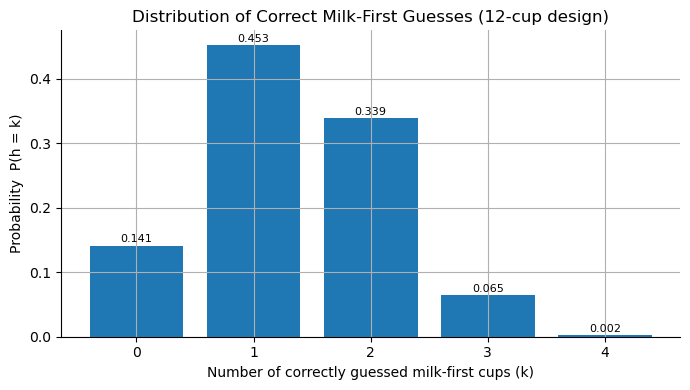

In [4]:
from math import comb
import pandas as pd

N, K, n = 12, 4, 4  # total cups, milk-first cups, guessed milk-first cups
dist = {k: (comb(K, k) * comb(N - K, n - k)) / comb(N, n) for k in range(0, n + 1)}
p_tail_ge3 = sum(dist[k] for k in range(3, n + 1))

dist_df = pd.DataFrame({
    "k = correct milk": list(dist.keys()),
    "P(h = k)": [dist[k] for k in dist]
}).sort_values("k = correct milk").reset_index(drop=True)

display(
    dist_df.style.format({"P(h = k)": "{:.6f}"})
    
)
print(f"P(h >= 3) = {p_tail_ge3:.6f}")
# --- Problem 1: Extending the Lady Tasting Tea ---------------------------------------------

# --- Bar chart for distribution of h (12-cup case) ---

fig, ax = plt.subplots(figsize=(7, 4))

# Bars: P(h = k) for k = 0, 1, 2, 3, 4
ax.bar(dist_df["k = correct milk"], dist_df["P(h = k)"])

ax.set_xlabel("Number of correctly guessed milk-first cups (k)")
ax.set_ylabel("Probability  P(h = k)")
ax.set_title("Distribution of Correct Milk-First Guesses (12-cup design)")

# Optional: annotate bars with probabilities
for idx, row in dist_df.iterrows():
    ax.text(
        row["k = correct milk"],
        row["P(h = k)"] + 0.002,
        f"{row['P(h = k)']:.3f}",
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.tight_layout()
plt.show()

### Interpretation

- **8-cup (4 vs 4):** $\Pr(\text{all correct}) = 1/\binom{8}{4} = 1/70 \approx 0.01429$.  
- **12-cup (8 vs 4):** $\Pr(\text{all correct}) = 1/\binom{12}{4} = 1/495 \approx 0.00202$.  

The extended design makes a perfect score **far less likely by chance**, so the same "all-correct" outcome yields **stronger evidence** against the null.

**On thresholds (p-values):**  
- Keeping $\alpha=0.05$ and requiring "all correct" remains valid and becomes **more stringent** in the 12-cup test ($p\approx0.002$).  
- If you wish to accept *near-perfect* performance (e.g., $h\ge3$ milk positions correct), you must pre-specify the rule and verify its size. For 12 cups, $\Pr(h\ge3)\approx0.0667$, which is **above 0.05**, so it is **not** a suitable 5% test by itself. 

In summary, the 12-cup variant strengthens evidence under the same rejection rule; any relaxed rule must be carefully calibrated to control [Type I error](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors).

---

## Problem 2 — Normal Distribution: sample vs population SD

### Plan & References

**Goal.** Draw 100,000 samples of size 10 from \( \mathcal{N}(0,1) \) and for each sample compute:

- the **sample SD** with `ddof=1`, and  
- the **population SD** with `ddof=0`.

Then:

- Plot both SD distributions on the same axes (with transparency).  
- Compare them visually and numerically.  
- Explain how you expect the differences to change as the sample size \( n \) increases.

**Documentation:**

- NumPy standard deviation (`numpy.std` and `ddof`):  
  https://numpy.org/doc/stable/reference/generated/numpy.std.html  
- Bessel’s correction (unbiased variance):  
  https://en.wikipedia.org/wiki/Bessel%27s_correction  
- Normal distribution (background):  
  https://en.wikipedia.org/wiki/Normal_distribution

,Estimator,Mean,Std of estimator,Median
0,ddof=1 (sample SD),0.9734,0.2330,0.9625
1,ddof=0 (population SD),0.9234,0.2211,0.9131


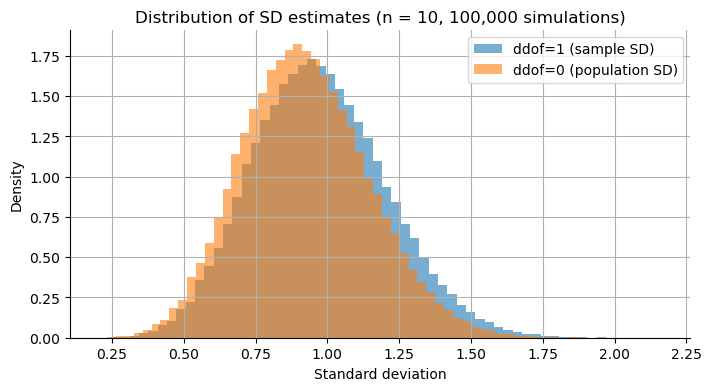

In [5]:
# --- Problem 2: Sample SD (ddof=1) vs Population SD (ddof=0) -------------------------------
# We quantify the difference between the sample SD and population SD estimators
# for many small samples drawn from N(0, 1).
#
# References:
# - numpy.std (ddof): https://numpy.org/doc/stable/reference/generated/numpy.std.html
# - Bessel’s correction: https://en.wikipedia.org/wiki/Bessel%27s_correction

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Fixed seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

def sds_from_normal(n_sims: int = 100_000, n: int = 10, seed: int = SEED):
    """
    Draw n_sims samples of size n from N(0,1) and compute two SD estimators.

    Returns
    -------
    sd_sample : np.ndarray
        Standard deviation with ddof=1 (sample SD, linked to unbiased variance).
    sd_pop : np.ndarray
        Standard deviation with ddof=0 (population SD / MLE under normality).
    """
    rng = np.random.default_rng(seed)

        # Each row is one sample of size n
    X = rng.normal(loc=0.0, scale=1.0, size=(n_sims, n))

    # ddof=1: sample SD (uses Bessel's correction for the variance)
    sd_sample = X.std(axis=1, ddof=1)

    # ddof=0: population SD (usual population formula)
    sd_pop = X.std(axis=1, ddof=0)

    return sd_sample, sd_pop

# Run the main experiment for n = 10
sd1, sd0 = sds_from_normal(n_sims=100_000, n=10)

# ---- Numerical summary ----
summary = pd.DataFrame({
    "Estimator": ["ddof=1 (sample SD)", "ddof=0 (population SD)"],
    "Mean": [sd1.mean(), sd0.mean()],
    "Std of estimator": [sd1.std(), sd0.std()],
    "Median": [np.median(sd1), np.median(sd0)],
})

display(summary.style.format({
    "Mean": "{:.4f}",
    "Std of estimator": "{:.4f}",
    "Median": "{:.4f}",
}))

# ---- Visual comparison: overlaid histograms ----
fig, ax = plt.subplots()

ax.hist(
    sd1,
    bins=60,
    density=True,
    alpha=0.6,
    label="ddof=1 (sample SD)",
)

ax.hist(
    sd0,
    bins=60,
    density=True,
    alpha=0.6,
    label="ddof=0 (population SD)",
)

ax.set_title("Distribution of SD estimates (n = 10, 100,000 simulations)")
ax.set_xlabel("Standard deviation")
ax.set_ylabel("Density")
ax.legend()
plt.show()

### Interpretation

From the **summary table** and overlapping histograms:

- With **n = 10**, the distribution for `ddof=1` tends to sit **slightly to the right** of the
  `ddof=0` distribution.  
  - This reflects that using `ddof=1` (Bessel’s correction) is designed to make the **variance**
    estimator unbiased, which also nudges the SD slightly upward for small samples.
- The `ddof=0` (population SD) estimator is slightly smaller on average in finite samples, but both
  estimators are **consistent**: as the sample size grows, they both concentrate near the true
  value \( \sigma = 1 \).

  **How does this change as n increases?**

- For small \( n \), the choice of `ddof` matters more — `ddof=1` corrects for the bias in the
  variance, and you see a slightly larger SD on average.
- As \( n \to \infty \), both estimators converge towards 1, and the difference between them
  becomes practically negligible.

In practice, for moderate and large samples the difference is tiny, but for **small** samples
using `ddof=1` is usually preferred when estimating a population SD from data.


#### Optional extension


,n,mean_sd_ddof1,mean_sd_ddof0,sd_sd_ddof1,sd_sd_ddof0
0,5,0.9422,0.8427,0.3410,0.3050
1,10,0.9740,0.9240,0.2332,0.2213
2,20,0.9862,0.9612,0.1608,0.1567
3,30,0.9919,0.9752,0.1312,0.1290
4,50,0.9949,0.9849,0.1001,0.0991
5,100,0.9977,0.9927,0.0708,0.0704


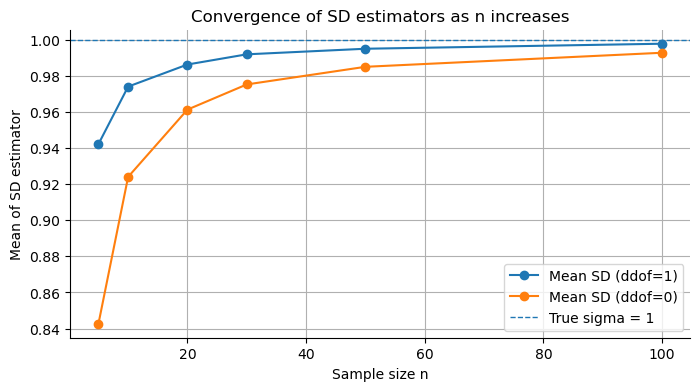

In [6]:
# --- Optional extension: effect of increasing n on SD estimators ----------------------------

def mean_sd_vs_n(n_list=(5, 10, 20, 30, 50, 100), n_sims: int = 50_000):
    """
    Compute the mean and variability of both SD estimators for several sample sizes.
    """
    rows = []
    for n in n_list:
        sd1_n, sd0_n = sds_from_normal(n_sims=n_sims, n=n, seed=SEED + n)
        rows.append({
            "n": n,
            "mean_sd_ddof1": sd1_n.mean(),
            "mean_sd_ddof0": sd0_n.mean(),
            "sd_sd_ddof1": sd1_n.std(),
            "sd_sd_ddof0": sd0_n.std(),
        })
    return pd.DataFrame(rows).sort_values("n")

df_n = mean_sd_vs_n()

display(df_n.style.format({
    "mean_sd_ddof1": "{:.4f}",
    "mean_sd_ddof0": "{:.4f}",
    "sd_sd_ddof1": "{:.4f}",
    "sd_sd_ddof0": "{:.4f}",
}))

fig, ax = plt.subplots()
ax.plot(df_n["n"], df_n["mean_sd_ddof1"], marker="o", label="Mean SD (ddof=1)")
ax.plot(df_n["n"], df_n["mean_sd_ddof0"], marker="o", label="Mean SD (ddof=0)")
ax.axhline(1.0, linestyle="--", linewidth=1, label="True sigma = 1")

ax.set_xlabel("Sample size n")
ax.set_ylabel("Mean of SD estimator")
ax.set_title("Convergence of SD estimators as n increases")
ax.legend()
plt.show()

*Optionally, I explored how these estimators behave for different sample sizes; as expected, both converge to σ = 1 and become nearly indistinguishable.*

---

## Problem 3 — t-Tests & Type II error (β)


### Plan & References

**Goal.** For each mean difference  
\( d \in \{0, 0.1, 0.2, \dots, 1.0\} \)  

we will:

1. Draw two independent samples of size 100:
   - Group A: \( X \sim \mathcal{N}(0, 1) \)
   - Group B: \( Y \sim \mathcal{N}(d, 1) \)
2. Run an **independent samples t-test** (two-sided) using `scipy.stats.ttest_ind`.
3. Reject the null hypothesis \( H_0: \mu_X = \mu_Y \) if \( p < 0.05 \).
4. Record the **proportion of times we do *not* reject** \( H_0 \):
   - When \( d > 0 \), this proportion estimates the **Type II error rate** \( \beta(d) \).
   - Power is \( 1 - \beta(d) \).

We repeat this **1,000 times** for each \( d \) and plot \( \beta(d) \) vs \( d \).

**Documentation:**

- SciPy independent t-test (`scipy.stats.ttest_ind`):  
  https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
- Type I and Type II errors (definitions and table):  
  https://en.wikipedia.org/wiki/Type_I_and_type_II_errors
- Statistical power:  
  https://en.wikipedia.org/wiki/Statistical_power


,d,beta_hat,power_hat
0,0.000000,0.941,0.059
1,0.100000,0.884,0.116
2,0.200000,0.728,0.272
3,0.300000,0.456,0.544
4,0.400000,0.199,0.801
5,0.500000,0.056,0.944
6,0.600000,0.014,0.986
7,0.700000,0.002,0.998
8,0.800000,0.000,1.000
9,0.900000,0.000,1.000


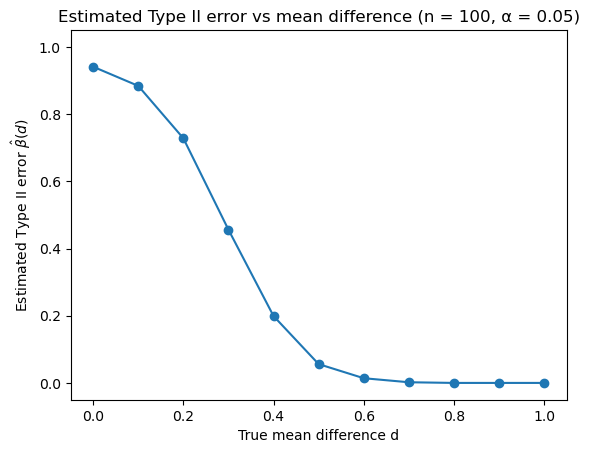

In [1]:
# --- Problem 3: t-Tests & Type II error (β) -----------------------------------
# We estimate the probability that a standard two-sample t-test FAILS to reject
# the null hypothesis, even though there is a true difference in means.
#
# For each d in {0, 0.1, ..., 1.0}:
#   - X ~ N(0, 1), Y ~ N(d, 1), n = 100 per group
#   - t-test with alpha = 0.05 (two-sided)
#   - Record proportion of p-values >= 0.05  → estimate of β(d)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

SEED = 42
rng = np.random.default_rng(SEED)

def simulate_type2_for_d(
    d: float,
    n: int = 100,
    n_reps: int = 1_000,
    alpha: float = 0.05,
    seed: int | None = None
) -> float:
    """
    Estimate Type II error rate β(d) for an independent samples t-test.

    Parameters
    ----------
    d : float
        True difference in means (group B has mean d, group A has mean 0).
    n : int
        Sample size per group.
    n_reps : int
        Number of simulated experiments to run.
    alpha : float
        Significance level for the test (default 0.05).
    seed : int or None
        Random seed for reproducibility.

    Returns
    -------
    beta_hat : float
        Estimated probability of NOT rejecting H0 (i.e. p >= alpha).
        For d > 0 this approximates the Type II error rate β(d).
    """
    rng = np.random.default_rng(seed)
    not_rejected = 0

    for _ in range(n_reps):
        # Group A from N(0, 1)
        x = rng.normal(loc=0.0, scale=1.0, size=n)

        # Group B from N(d, 1)
        y = rng.normal(loc=d, scale=1.0, size=n)

        # Two-sample independent t-test (assume equal variances is default)
        # SciPy docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
        t_stat, p_value = stats.ttest_ind(x, y, equal_var=True)

        # Type II error occurs when we FAIL to reject H0 even though it is false
        if p_value >= alpha:
            not_rejected += 1

    # Proportion of non-rejections
    beta_hat = not_rejected / n_reps
    return beta_hat

# Grid of mean differences d
d_values = [0.1 * i for i in range(0, 11)]  # [0.0, 0.1, ..., 1.0]

results = []
for i, d in enumerate(d_values):
    # Offset the seed slightly for each d to avoid reusing exactly the same streams
    beta_hat = simulate_type2_for_d(
        d=d,
        n=100,
        n_reps=1_000,
        alpha=0.05,
        seed=SEED + i
    )
    results.append({"d": d, "beta_hat": beta_hat, "power_hat": 1 - beta_hat})

results_df = pd.DataFrame(results)

display(results_df.style.format({"beta_hat": "{:.3f}", "power_hat": "{:.3f}"}))

# --- Plot β(d) vs d -----------------------------------------------------------

fig, ax = plt.subplots()

ax.plot(results_df["d"], results_df["beta_hat"], marker="o")
ax.set_xlabel("True mean difference d")
ax.set_ylabel(r"Estimated Type II error $\hat{\beta}(d)$")
ax.set_title("Estimated Type II error vs mean difference (n = 100, α = 0.05)")
ax.set_ylim(-0.05, 1.05)
plt.show()


### Interpretation

From the table and the plot of \( \hat{\beta}(d) \) vs \( d \):

- At **\( d = 0 \)**:
  - The null hypothesis is actually **true**.
  - The proportion of *non-rejections* is close to **0.95**, which matches \( 1 - \alpha \)
    (since we only reject about 5% of the time when the null is true).
  - Strictly speaking, this point is about **Type I error** control rather than Type II error.

- As **\( d \) increases** from 0 towards 1:
  - The t-test becomes more sensitive to the difference between the two group means.
  - The estimated **Type II error rate \( \hat{\beta}(d) \)** **decreases**.
  - Equivalently, the **power** \( 1 - \beta(d) \) **increases**, meaning we are more likely to
    correctly reject \( H_0 \) when it is false.

For sufficiently large \( d \) (relative to the sample size and noise level):

- The test almost always detects the difference, so \( \beta(d) \) gets close to **0** and power
  gets close to **1**.
- In this simulation with \( n = 100 \), by the time \( d \) reaches around 0.8–1.0, the Type II
  error rate is typically **very small**, indicating a highly powered test.

**Key idea.** Type II error is highest when the true effect is **small but non-zero**; the test
struggles in the “borderline” region where the signal is only slightly stronger than the noise.
Increasing the **effect size**, the **sample size**, or using a **larger α** (less strict test)
all act to **reduce** \( \beta \) and therefore **increase** power.

---

## Problem 4 — ANOVA vs multiple t-tests


### Plan & References

**Goal.**  

1. Generate three independent samples, each of size 30, from:
   - Group 1: \( \mathcal{N}(0,\;1) \)
   - Group 2: \( \mathcal{N}(0.5,\;1) \)
   - Group 3: \( \mathcal{N}(1,\;1) \)
2. Perform a **one-way ANOVA** to test:
   \[
   H_0:\ \mu_1 = \mu_2 = \mu_3
   \]
3. Perform three independent two-sample t-tests:
   - Group 1 vs Group 2  
   - Group 1 vs Group 3  
   - Group 2 vs Group 3
4. Compare the conclusions of ANOVA and the individual t-tests.
5. Write a short note on **why ANOVA is preferred** to simply running several t-tests.


**Documentation:**

- One-way ANOVA in SciPy:  
  https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html  
- Two-sample t-test (`scipy.stats.ttest_ind`):  
  https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html  
- One-way ANOVA (concept):  
  https://en.wikipedia.org/wiki/One-way_analysis_of_variance  
- Multiple comparisons and family-wise error rate:  
  https://en.wikipedia.org/wiki/Family-wise_error_rate

,value,group
0,0.304717,Group 1
1,-1.039984,Group 1
2,0.750451,Group 1
3,0.940565,Group 1
4,-1.951035,Group 1


One-way ANOVA results
---------------------
F statistic: 10.5746
p-value    : 0.0001



,Comparison,t statistic,p-value,Reject H0 at α=0.05?
0,Group 1 vs Group 2,-2.9233,0.0049,True
1,Group 1 vs Group 3,-4.6566,0.0000,True
2,Group 2 vs Group 3,-1.4735,0.1460,False


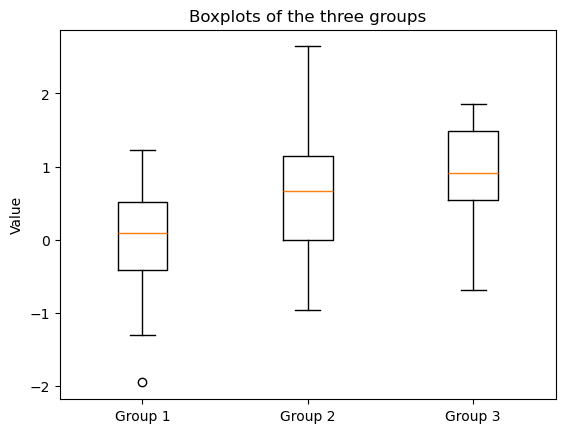

In [1]:
# --- Problem 4: ANOVA vs multiple t-tests ------------------------------------
# We simulate three groups with different means and compare:
#   - A global one-way ANOVA
#   - Pairwise independent t-tests
#
# Group sizes: n = 30
# Means: 0, 0.5, 1
# SD: 1 for each group

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

SEED = 42
rng = np.random.default_rng(SEED)

# ---- 1. Generate the three samples ------------------------------------------

n = 30
mu1, mu2, mu3 = 0.0, 0.5, 1.0
sigma = 1.0

group1 = rng.normal(loc=mu1, scale=sigma, size=n)
group2 = rng.normal(loc=mu2, scale=sigma, size=n)
group3 = rng.normal(loc=mu3, scale=sigma, size=n)

# Put into a DataFrame for convenience and possible plotting
df = pd.DataFrame({
    "value": np.concatenate([group1, group2, group3]),
    "group": (["Group 1"] * n) + (["Group 2"] * n) + (["Group 3"] * n),
})

display(df.head())

# ---- 2. One-way ANOVA -------------------------------------------------------
# SciPy docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html

f_stat, p_anova = stats.f_oneway(group1, group2, group3)

print("One-way ANOVA results")
print("---------------------")
print(f"F statistic: {f_stat:.4f}")
print(f"p-value    : {p_anova:.4f}")
print()

# ---- 3. Pairwise independent t-tests ----------------------------------------
# SciPy docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

groups = {
    "Group 1": group1,
    "Group 2": group2,
    "Group 3": group3,
}

pairs = [("Group 1", "Group 2"),
         ("Group 1", "Group 3"),
         ("Group 2", "Group 3")]

ttest_rows = []
alpha = 0.05

for g1_name, g2_name in pairs:
    x = groups[g1_name]
    y = groups[g2_name]

    t_stat, p_val = stats.ttest_ind(x, y, equal_var=True)
    ttest_rows.append({
        "Comparison": f"{g1_name} vs {g2_name}",
        "t statistic": t_stat,
        "p-value": p_val,
        "Reject H0 at α=0.05?": p_val < alpha,
    })

ttests_df = pd.DataFrame(ttest_rows)
display(ttests_df.style.format({"t statistic": "{:.4f}", "p-value": "{:.4f}"}))

# ---- 4. Simple visualisation (optional but helpful) -------------------------

fig, ax = plt.subplots()
ax.boxplot(
    [group1, group2, group3],
    tick_labels=["Group 1", "Group 2", "Group 3"],
)

ax.set_title("Boxplots of the three groups")
ax.set_ylabel("Value")
plt.show()
